# San Francisco Crime Classification

## Predict the category of crimes that occurred in the city by the bay
From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

## What we will do here
* Training a machine learning model with scikit-learn
* Use the ***K-nearest neighbors*** classification model

## How does K-Nearest Neighbors (KNN) classification work?
1. Pick a value for K.
1. Search for the K observations in the training data that are "nearest" to the measurements of the crime category.
1. Use the most popular response value from the K nearest neighbors as the predicted response value for the unknown crime category.

## Resources
* [Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html) (user guide), [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) (class documentation)


In [16]:
# Step 1 - importing classes we plan to use
import csv as csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# show plots inline
%matplotlib inline

In [34]:
#
# Preparing the data
#
data = pd.read_csv('../input/train.csv',parse_dates=['Dates'], dtype={"X": np.float64,"Y": np.float64}, )

# Add column containing day of week expressed in integer
dow = {
    'Monday':0,
    'Tuesday':1,
    'Wednesday':2,
    'Thursday':3,
    'Friday':4,
    'Saturday':5,
    'Sunday':6
}
data['DOW'] = data.DayOfWeek.map(dow)

# Add column containing time of day
data['Hour'] = pd.to_datetime(data.Dates).dt.hour
# display the first 5 rows
data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,DOW,Hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2,23


## Time vs. Day by category

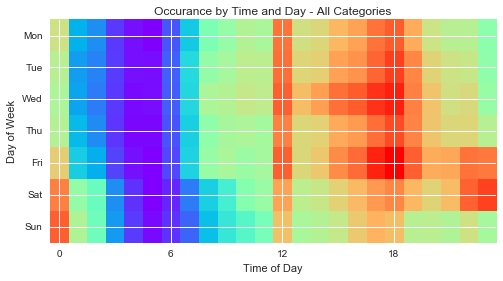

In [35]:
# Retrieve categories list
cats = pd.Series(data.Category.values.ravel()).unique()
cats.sort()
#
# First, take a look at the total of all categories
#

plt.figure(1,figsize=(8,4))
plt.hist2d(
    data.Hour.values,
    data.DOW.values,
    bins=[24,7],
    range=[[-0.5,23.5],[-0.5,6.5]],
    cmap=plt.cm.rainbow
)
plt.xticks(np.arange(0,24,6))
plt.xlabel('Time of Day')
plt.yticks(np.arange(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Day of Week')
plt.gca().invert_yaxis()
plt.title('Occurance by Time and Day - All Categories')

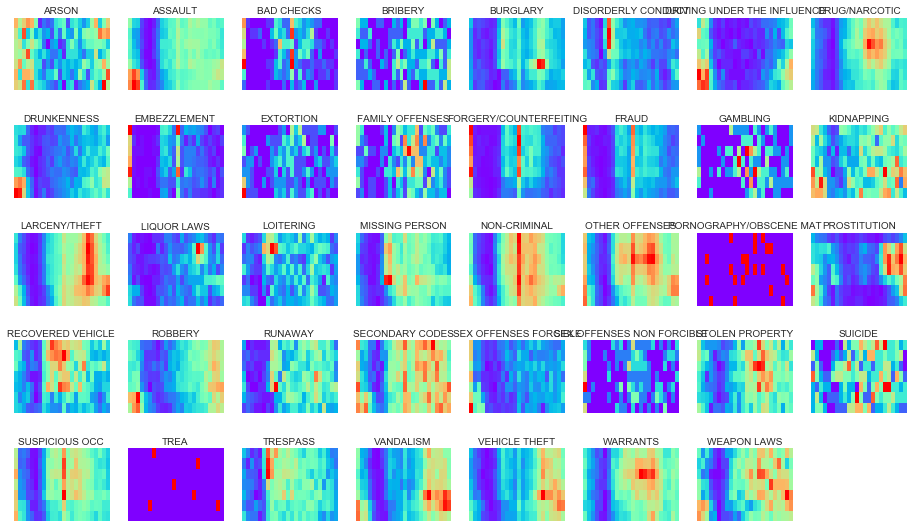

In [11]:
#
# Now look into each category
#

plt.figure(2,figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
for i in np.arange(1,cats.size + 1):
    ax = plt.subplot(5,8,i)
    ax.set_title(cats[i - 1],fontsize=10)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.hist2d(
        data[data.Category==cats[i - 1]].Hour.values,
        data[data.Category==cats[i - 1]].DOW.values, 
        bins=[24,7],
        range=[[-0.5,23.5],[-0.5,6.5]],
        cmap=plt.cm.rainbow
    )
    plt.gca().invert_yaxis()


## scikit-learn 4-step modeling pattern
***Step 1:***Import the class you plan to use

***Step 2:*** "Instantiate" the "estimator"
* "Estimator" is scikit-learn's term for model
* "Instantiate" means "make an instance of"
* Name of the object does not matter
* Can specify tuning parameters (aka "hyperparameters") during this step
* All parameters not specified are set to their defaults

***Step 3:*** Fit the model with data (aka "model training")
* Model is learning the relationship between X and y
* Occurs in-place

***Step 4:*** Predict the response for a new observation
* New observations are called "out-of-sample" data
* Uses the information it learned during the model training process

## Fitting the data
Ok, so what are we actually trying to do? ***Given location, you must predict the category of crime that occurred.*** 
* Store feature matrix in X - this will be the location inputs
* Store response in y - this will be the category of crime, since that is what we are prediciting

In [18]:
# Separate test and train set out of orignal train set.
msk = np.random.rand(len(data)) < 0.8
knn_train = data[msk]
knn_test = data[~msk]
n = len(knn_test)
print("Original size: %s" % len(data))
print("Train set: %s" % len(knn_train))
print("Test set: %s" % len(knn_test))
# Prepare data sets
x = knn_train[['X', 'Y']]
y = knn_train['Category'].astype('category')
actual = knn_test['Category'].astype('category')

# Fit
import scipy as sp
def llfun1(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll
def llfun(act, pred):
    """ Logloss function for 1/0 probability
    """
    return (-(~(act == pred)).astype(int) * math.log(1e-15)).sum() / len(act)

logloss = []
for i in range(1, 50, 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x, y)
    
    # Predict on test set
    outcome = knn.predict(knn_test[['X', 'Y']])
    
    # Logloss
    logloss.append(llfun(actual, outcome))


Original size: 878049
Train set: 702442
Test set: 175607


# Logarithmic Loss
https://www.kaggle.com/wiki/LogarithmicLoss

The logarithm of the likelihood function for a Bernouli random distribution.

In plain English, this error metric is used where contestants have to predict that something is true or false with a probability (likelihood) ranging from definitely true (1) to equally true (0.5) to definitely false(0).

The use of log on the error provides extreme punishments for being both confident and wrong. In the worst possible case, a single prediction that something is definitely true (1) when it is actually false will add infinite to your error score and make every other entry pointless. In Kaggle competitions, predictions are bounded away from the extremes by a small value in order to prevent this.

Let's plot it as a function of k for our nearest neighbor 

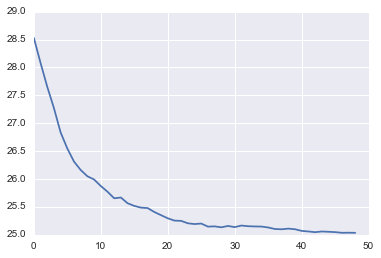

In [19]:
plt.plot(logloss)
plt.savefig('n_neighbors_vs_logloss.png')

based on the log loss we can see that around 40 is optimal for k. Now lets predict using the test data

In [20]:
# Submit for K=40
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(x, y)

# predict from our test set
test = pd.read_csv('../input/test.csv',parse_dates=['Dates'], dtype={"X": np.float64,"Y": np.float64}, )
x_test = test[['X', 'Y']]
outcomes = knn.predict(x_test)

submit = pd.DataFrame({'Id': test.Id.tolist()})
for category in y.cat.categories:
    submit[category] = np.where(outcomes == category, 1, 0)
    
submit.to_csv('k_nearest_neigbour.csv', index = False)

## Can we do better?
Maybe we can try with more features than just lat and lon
But first, our data is not very useful as text. So let's map the strings to ints so that we can use them later

In [36]:
# map pd district to int
unique_pd_district = data["PdDistrict"].unique()
pd_district_mapping = {}
i=0
for c in unique_pd_district:
    pd_district_mapping[c] = i
    i += 1
data['PdDistrictId'] = data.PdDistrict.map(pd_district_mapping)
print(data.describe())
data.tail()

                   X              Y            DOW           Hour  \
count  878049.000000  878049.000000  878049.000000  878049.000000   
mean     -122.422616      37.771020       2.992691      13.412655   
std         0.030354       0.456893       1.972023       6.549573   
min      -122.513642      37.707879       0.000000       0.000000   
25%      -122.432952      37.752427       1.000000       9.000000   
50%      -122.416420      37.775421       3.000000      14.000000   
75%      -122.406959      37.784369       5.000000      19.000000   
max      -120.500000      90.000000       6.000000      23.000000   

        PdDistrictId  
count  878049.000000  
mean        5.037957  
std         3.114945  
min         0.000000  
25%         2.000000  
50%         5.000000  
75%         8.000000  
max         9.000000  


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,DOW,Hour,PdDistrictId
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,0,0,6
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,0,0,2
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,0,0,9
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,0,0,9
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212,0,0,3


In [37]:
# store feature matrix in "X"
X = data[['Hour','DOW','X','Y','PdDistrictId']]

# store response vector in "y"
y = data['Category'].astype('category')

# Submit for K=40
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X, y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=40, p=2,
           weights='uniform')

In [38]:
test = pd.read_csv('../input/test.csv',parse_dates=['Dates'], dtype={"X": np.float64,"Y": np.float64}, )

In [39]:
# clean up test set
test['DOW'] = test.DayOfWeek.map(dow)
test['Hour'] = pd.to_datetime(test.Dates).dt.hour
test['PdDistrictId'] = test.PdDistrict.map(pd_district_mapping)
test.tail()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,DOW,Hour,PdDistrictId
884257,884257,2003-01-01 00:01:00,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987,2,0,8
884258,884258,2003-01-01 00:01:00,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681,2,0,0
884259,884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075,2,0,2
884260,884260,2003-01-01 00:01:00,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479,2,0,3
884261,884261,2003-01-01 00:01:00,Wednesday,TARAVAL,1500 Block of SLOAT BL,-122.489714,37.733950,2,0,6


In [40]:
# Predictions for the test set
X_test = test[['Hour','DOW','X','Y','PdDistrictId']]
outcomes = knn.predict(X_test)

submit = pd.DataFrame({'Id': test.Id.tolist()})
for category in y.cat.categories:
    submit[category] = np.where(outcomes == category, 1, 0)
    
submit.to_csv('k_nearest_neigbour_2.csv', index = False)

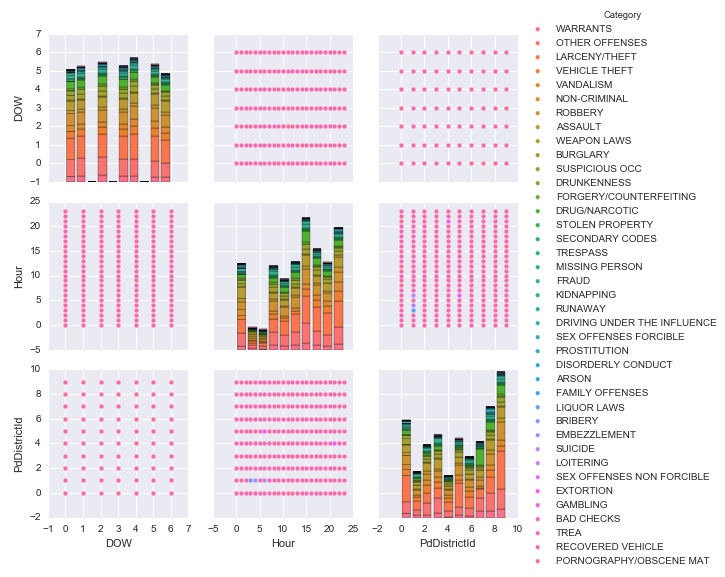

In [41]:
# lets see how much dow, hour and district correlate to category
plt.figure()
sns.pairplot(data=data[["Category","DOW","Hour","PdDistrictId"]],
             hue="Category", dropna=True)

In [42]:
plt.savefig("seaborn_pair_plot.png")

In [46]:
import csv as csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

# show plots inline

# Add column containing day of week expressed in integer
dow = {
    'Monday':0,
    'Tuesday':1,
    'Wednesday':2,
    'Thursday':3,
    'Friday':4,
    'Saturday':5,
    'Sunday':6
}

data = pd.read_csv('../input/train.csv',parse_dates=['Dates'], dtype={"X": np.float64,"Y": np.float64}, )
data['DOW'] = data.DayOfWeek.map(dow)
data['Hour'] = pd.to_datetime(data.Dates).dt.hour
X = data[['Hour','DOW','X','Y']]
y = data['Category'].astype('category')
knn = KNeighborsClassifier(n_neighbors=39)
knn.fit(X, y)

test = pd.read_csv('../input/test.csv',parse_dates=['Dates'], dtype={"X": np.float64,"Y": np.float64}, )
test['DOW'] = test.DayOfWeek.map(dow)
test['Hour'] = pd.to_datetime(test.Dates).dt.hour
X_test = test[['Hour','DOW','X','Y']]
outcomes = knn.predict(X_test)
submit = pd.DataFrame({'Id': test.Id.tolist()})
for category in y.cat.categories:
    submit[category] = np.where(outcomes == category, 1, 0)
    
submit.to_csv('k_nearest_neigbour3.csv', index = False)